In [1]:
#%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import feather, h5py, sys, pickle
from shapely.geometry import Point, Polygon
#from geocube.api.core import make_geocube
import xagg as xa
import netCDF4
import geopandas
import feather 
import cmocean
import scipy

import sys
sys.path.append('../')
import utils
import plotting

import difflib 

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [2]:
#import dataset
df1 = pd.read_csv('./final_data/df_pm_o3_county_nuclear_geo_avg.csv', index_col = 0)

In [3]:
#import dataset
df2 = pd.read_csv('./final_data/df_pm_o3_county_nuclear_geo_avg_nocoal.csv', index_col = 0)

In [4]:
df = df1.merge(df2, on = ['COUNTYNS','County_State','geometry_county','nuclear_adjacent', 'coal_containing','CountyName','StateName'], suffixes = ("_nonuc", "_nonuc_coal"))

In [5]:
df['County_State'] = df['County_State'].str.lower()

Mortality data from: https://wonder.cdc.gov/controller/datarequest/D140;jsessionid=3706D5550499EA883D9361BB7FC6
Centers for Disease Control and Prevention, National Center for Health Statistics. Compressed Mortality File 1999-2016 on CDC WONDER Online Database, released June 2017. Data are from the Compressed Mortality File 1999-2016 Series 20 No. 2U, 2016, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/cmf-icd10.html on Jul 13, 2021 2:41:50 PM

In [6]:
mort_df = pd.read_excel('data/compressed_mortality_cdc.xlsx')
mort_df = mort_df.drop(columns = 'Notes')
mort_df.dropna(inplace = True)

In [7]:
mort_df2 = pd.read_excel('./data/compressed_mortality_cdc_hispanic.xlsx')
mort_df2 = mort_df2.drop(columns = {'Notes'})
mort_df2.dropna(inplace = True)

In [8]:
mort_df.rename(columns = {'Race':'Race/Hispanic Origin'}, inplace = True)
mort_df2.rename(columns = {'Hispanic Origin':'Race/Hispanic Origin'}, inplace = True)

In [9]:
mort_df = pd.concat([mort_df, mort_df2])
mort_df.loc[mort_df['Population'] == 'Not Applicable','Population'] = np.nan

In [10]:
mort_df['County'] = mort_df['County'].astype('string')
mort_df[['county','state']] = mort_df['County'].str.split(', ',expand=True)

In [11]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [12]:
mort_df['state'] = mort_df['state'].map(lambda x: x.replace(" ", ""))
state_list = [states[i] for i in mort_df['state'].values]
mort_df['state'] = state_list

In [13]:
mort_df['county'] = mort_df['county'].str.replace(' Parish', '')
mort_df['county'] = mort_df['county'].str.replace(' County', '')
mort_df['county'] = mort_df['county'].str.replace(' city', '')
mort_df.loc[(mort_df['county'] == 'Shannon') & (mort_df['state'] == 'South Dakota'), 'county'] = 'Oglala Lakota'

In [14]:
mort_df['county'] = mort_df['county'].str.lower()
mort_df['state'] = mort_df['state'].str.lower()

In [15]:
mort_df['County_State'] = mort_df['county'] + ', ' + mort_df['state']

In [16]:
poll_df = df[df.StateName.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]

In [17]:
mort_df = mort_df[mort_df.state.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]


In [18]:
#find dif between two lists:
for cs in list(set(mort_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


debaca, new mexico []
la porte, indiana []
mc kean, pennsylvania []
dona ana, new mexico []
de kalb, indiana []


In [19]:
poll_df.loc[poll_df['County_State'] == 'laporte, indiana', 'County_State'] = 'la porte, indiana'
poll_df.loc[poll_df['County_State'] == 'mckean, pennsylvania', 'County_State'] = 'mc kean, pennsylvania'
poll_df.loc[poll_df['County_State'] == 'doña ana, new mexico', 'County_State'] = 'dona ana, new mexico'
poll_df.loc[poll_df['County_State'] == 'dekalb, indiana', 'County_State'] = 'de kalb, indiana'
poll_df.loc[poll_df['County_State'] == 'de baca, new mexico', 'County_State'] = 'debaca, new mexico'

In [20]:
#find dif between two lists:
for cs in list(set(mort_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


In [21]:
#merged mortality and poll data
combined_df = mort_df.merge(poll_df, on = 'County_State')
combined_df['Population'] = combined_df['Population'].fillna(-9999) #get rid of the nans
combined_df = combined_df.loc[combined_df['Population'] != np.nan]

In [22]:
#create geo dataframe
combined_df['geometry'] = geopandas.GeoSeries.from_wkt(combined_df['geometry_county'])
geo_df = geopandas.GeoDataFrame(combined_df, geometry='geometry')
combined_df = geo_df.copy()

In [23]:
#convet to ppb
combined_df['O3_nonuc']*=1e9
combined_df['O3_nonuc_coal']*=1e9

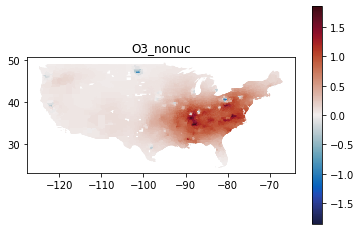

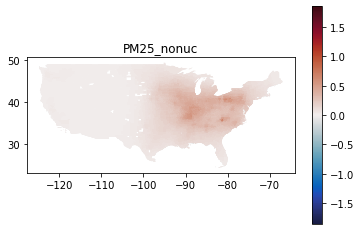

In [24]:
#check that they look reasonable
for p in ['O3_nonuc','PM25_nonuc']:
    combined_df.plot(column = p, legend=True, 
                                         vmin = -1.85, vmax = 1.85, 
                                         cmap = cmocean.cm.balance)
    plt.title( p)


## Maps of higher risk counties

In [39]:


states = geopandas.read_file('data/cb_2018_us_state_500k.shx')
states = states.rename(columns = {'NAME':'StateName'})


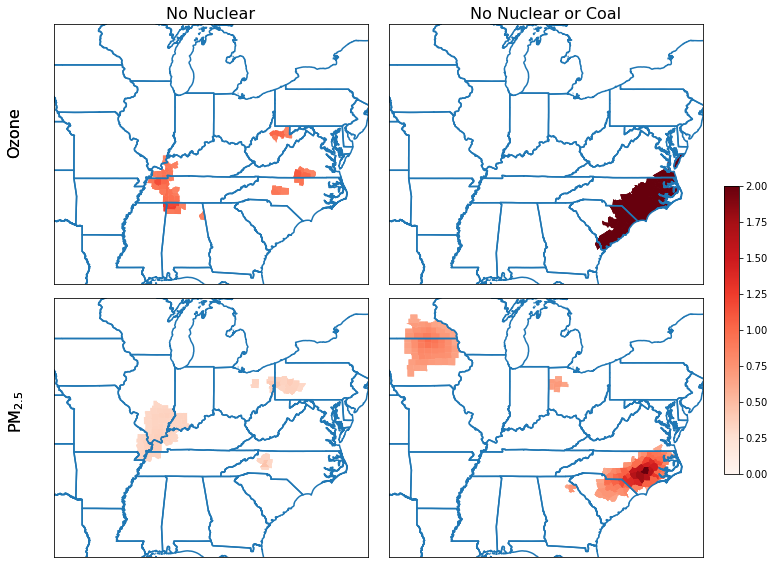

In [105]:
fig, axes = plt.subplots(2,2, figsize = (10,8))
for idx, run in enumerate(['nonuc','nonuc_coal']):
    ax = axes[0,idx]
    threshold = combined_df[f'O3_{run}'].mean() + 2*combined_df[f'O3_{run}'].std()
    q = combined_df.loc[combined_df[f'O3_{run}']>threshold].plot(ax = ax, column = f'O3_{run}', legend=False, 
                                             vmin = 0, vmax = 3, 
                                             cmap = 'Reds')
    states.boundary.plot(ax = ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-96,-74])
    ax.set_ylim(30,46)
    axes[0, 0].annotate(r'Ozone', xy=(-.15, 0.5), xycoords = 'axes fraction', fontsize = 16, rotation = 90)

    
    ax = axes[1,idx]
    threshold = combined_df[f'PM25_{run}'].mean() + 2*combined_df[f'PM25_{run}'].std()
    q = combined_df.loc[combined_df[f'PM25_{run}']>threshold].plot(ax = ax, column = f'PM25_{run}', legend=False, 
                                             vmin = 0, vmax = 3, 
                                             cmap = 'Reds')
    states.boundary.plot(ax = ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-96,-74])
    ax.set_ylim(30,46)
    axes[1, 0].annotate(r'PM$_{2.5}$', xy=(-.15, 0.5), xycoords = 'axes fraction', fontsize = 16, rotation = 90)
    
    axes[0,1].set_title(f'No Nuclear or Coal', fontsize = 16)
    axes[0,0].set_title(f'No Nuclear', fontsize = 16)
plt.tight_layout()

# Add single colorbar
cax = fig.add_axes([1.0, 0.17, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin = 0, vmax = 2))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
plt.savefig('Figures/at_risk_counties.png', bbox_inches = 'tight', dpi = 150)

## Beta calculations for PM

In [72]:
np.unique(combined_df['Race/Hispanic Origin'] )

array(['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
       'Not Hispanic or Latino', 'Not Stated', 'White'], dtype=object)

In [73]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_mean'] = 1.208
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_mean'] = 1.063
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_mean'] = 1.096
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_mean'] = 1.116
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_mean'] = 1.100

combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_low'] = 1.199
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_low'] = 1.060
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_low'] = 1.075
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_low'] = 1.100
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_low'] = 1.060

combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_high'] = 1.217
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_high'] = 1.065
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_high'] = 1.117
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_high'] = 1.133
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_high'] = 1.140

In [74]:
delta_chi = 10 #ug/m3
for sub in ['_mean', '_low', '_high']:
    for run in ['nonuc','nonuc_coal']:
        combined_df[f'β_PM{sub}'] = np.log(combined_df[f'RR_PM{sub}'])/delta_chi
        combined_df['mortality_0'] = combined_df['Deaths']/combined_df['Population']
        combined_df[f'Δmortality_PM{sub}_{run}'] =  combined_df[f'PM25_{run}']* combined_df['Population'] * combined_df['mortality_0'] * combined_df[f'β_PM{sub}']



# Calculations for Ozone

RR from Di et al. 
ΔM≃β_LL×I_OBS×(Δχ×p_aff )   

In [75]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_mean'] = 1.009
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_mean'] = 1.013
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_mean'] = .980
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_mean'] = .975
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_mean'] = .961

In [76]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_low'] = 1.005
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_low'] = 1.012
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_low'] = .972
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_low'] = .968
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_low'] = .944

In [77]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_high'] = 1.012
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_high'] = 1.014
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_high'] = .988
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_high'] = .981
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_high'] = .978

In [78]:
delta_chi = 10 #ppb
for sub in ['_mean', '_low', '_high']:
    for run in ['nonuc','nonuc_coal']:
        combined_df[f'β_O3{sub}'] = np.log(combined_df[f'RR_O3{sub}'])/delta_chi
        combined_df[f'Δmortality_O3{sub}_{run}'] =  combined_df[f'O3_{run}']* combined_df['Population'] * combined_df['mortality_0'] * combined_df[f'β_O3{sub}']



## Additional Calculations

In [79]:
geometry_df = combined_df.groupby(
    ['County_State','Race/Hispanic Origin','nuclear_adjacent']).first()

In [80]:
for run in ['nonuc','nonuc_coal']:
    combined_df['O3_mortalities/population'] = combined_df[f'Δmortality_O3_mean_{run}']/combined_df['Population']*1e5
    combined_df['PM_mortalities/population'] = combined_df[f'Δmortality_PM_mean_{run}']/combined_df['Population']*1e5

In [81]:
final_df = combined_df.groupby(['County_State','Race/Hispanic Origin','nuclear_adjacent', 'coal_containing']).mean()

In [82]:
final_df = final_df.join(geometry_df['geometry'])

## Percent of population exposed

In [83]:
percent_dict = {}
for re in ['White', 'American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino'
        ]:
    for run in ['nonuc','nonuc_coal']:
        percent_dict[re + ' pop'] = pd.DataFrame(combined_df[combined_df['Race/Hispanic Origin'] == re].set_index('County_State')['Population']/combined_df.groupby('County_State').sum()['Population']).rename(columns = {'Population': re + ' pop'})
        percent_dict[re + ' O3' + run] = pd.DataFrame(combined_df[combined_df['Race/Hispanic Origin'] == re].set_index('County_State')[f'Δmortality_O3_mean_{run}']/combined_df.groupby('County_State').sum()[f'Δmortality_O3_mean_{run}']).rename(columns = {f'Δmortality_O3_mean_{run}': re + ' O3' + run})
        percent_dict[re + ' PM' + run] = pd.DataFrame(combined_df[combined_df['Race/Hispanic Origin'] == re].set_index('County_State')[f'Δmortality_PM_mean_{run}']/combined_df.groupby('County_State').sum()[f'Δmortality_PM_mean_{run}']).rename(columns = {f'Δmortality_PM_{run}': re + ' PM' + run})

In [84]:
for idx in list(percent_dict.keys()):
    percent_dict[idx] = percent_dict[idx].merge(pd.DataFrame(combined_df.groupby('County_State').first()['geometry']), on = 'County_State')

In [85]:
geo_perc_dict = {}
for idx in list(percent_dict.keys()):

    geo_perc_dict[idx] = geopandas.GeoDataFrame(percent_dict[idx], geometry='geometry')

# Analysis

In [88]:
for run in ['nonuc','nonuc_coal']:
    print(final_df[f'Δmortality_O3_mean_{run}'].sum())

1229.5497432849038
1775.189563612691


In [89]:
for run in ['nonuc','nonuc_coal']:
    print(final_df[f'Δmortality_PM_mean_{run}'].sum())

4124.384146503804
4629.099473706687


## Exposure Difference by Coal Containing or Not

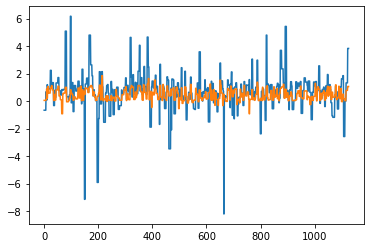

In [90]:
plt.plot(final_df.xs(True, level = 3)[f'O3_nonuc_coal'].values)
plt.plot(final_df.xs(True, level = 3)[f'O3_nonuc'].values)


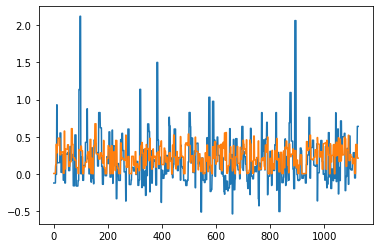

In [91]:
plt.plot(final_df.xs(True, level = 3)[f'PM25_nonuc_coal'].values)
plt.plot(final_df.xs(True, level = 3)[f'PM25_nonuc'].values)


In [92]:
for run in ['nonuc','nonuc_coal']:
    print('Near', 'PM', run)
    print(final_df.xs(True, level = 3)[f'PM25_{run}'].groupby('County_State').mean().mean())
    #print('Not', run)
    #print(final_df.xs(False, level = 3)[f'PM25_{run}'].groupby('County_State').mean().mean())
    print('Near', 'O3', run)
    print(final_df.xs(True, level = 3)[f'O3_{run}'].groupby('County_State').mean().mean())
    #print('Not', run)
    #print(final_df.xs(False, level = 3)[f'O3_{run}'].groupby('County_State').mean().mean())

Near PM nonuc
0.24032922562965486
Near O3 nonuc
0.47038026768613417
Near PM nonuc_coal
0.16926011962130533
Near O3 nonuc_coal
0.7272201788919592


### statistical significance

In [93]:
## statistical significance of the difference between pollution near a coal plant when just nuclear is shut down vs. nuclear and coal are shut down
for run in [True, False]:
    print('near coal', run)
    for poll in ['O3','PM25']:
        print(poll, ': ')
        print(scipy.stats.ttest_ind(final_df.xs(run, level = 3)[f'{poll}_nonuc_coal'].groupby('County_State').mean(),
                             final_df.xs(run, level = 3)[f'{poll}_nonuc'].groupby('County_State').mean(),
                             equal_var = False))

near coal True
O3 : 
Ttest_indResult(statistic=3.0799864909716956, pvalue=0.0022252958312703654)
PM25 : 
Ttest_indResult(statistic=-3.3312676633840455, pvalue=0.0009390253829744851)
near coal False
O3 : 
Ttest_indResult(statistic=10.781600009381759, pvalue=1.2339234671163277e-26)
PM25 : 
Ttest_indResult(statistic=0.7624497391841101, pvalue=0.44584237574573626)


### Mortality Difference by Coal County

In [71]:
for run in ['nonuc', 'nonuc_coal']:
    print(run)
    print('PM, near: ', (final_df.xs(True, level = 3)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(True, level = 3)['Population'].sum())*1e6)
    print('PM, not: ', (final_df.xs(False, level = 3)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(False, level = 3)['Population'].sum())*1e6)
    print('O3, near: ', (final_df.xs(True, level = 3)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(True, level = 3)['Population'].sum())*1e6)
    print('O3, not: ', (final_df.xs(False, level = 3)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(False, level = 3)['Population'].sum())*1e6)

nonuc
PM, near:  8.52736776207943
PM, not:  5.989799788930097
O3, near:  1.8994745617299151
O3, not:  1.9479105607834888
nonuc_coal
PM, near:  7.837652357426558
PM, not:  7.160358948082051
O3, near:  1.7862525247709113
O3, not:  3.0537259583823615


### statistical significance

In [72]:
for poll in ['O3','PM']:
    print(poll, ': ')
    for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
   'Black or African American', 'Hispanic or Latino',
    'White']:
        print(re, ': ')
        for opt in [True]:
            print('coal county, ', opt, ': ')
            print(scipy.stats.ttest_ind(final_df.xs(opt, level = 3).xs(re, level = 1)[f'Δmortality_{poll}_mean_nonuc_coal']/final_df.xs(opt, level = 3).xs(re, level = 1)['Population'],
                                 final_df.xs(opt, level = 3).xs(re, level = 1)[f'Δmortality_{poll}_mean_nonuc']/final_df.xs(opt, level = 3).xs(re, level = 1)['Population'],
                                #nan_policy = 'omit',
                                 equal_var = True))

O3 : 
American Indian or Alaska Native : 
coal county,  True : 
Ttest_indResult(statistic=-0.44848880762582943, pvalue=0.6546092368762682)
Asian or Pacific Islander : 
coal county,  True : 
Ttest_indResult(statistic=-0.8263723684119822, pvalue=0.4097377432236381)
Black or African American : 
coal county,  True : 
Ttest_indResult(statistic=3.6609772131637928, pvalue=0.0002870201526021297)
Hispanic or Latino : 
coal county,  True : 
Ttest_indResult(statistic=-0.35517265177491963, pvalue=0.7227334962545304)
White : 
coal county,  True : 
Ttest_indResult(statistic=3.3917973288274483, pvalue=0.0007385310514065911)
PM : 
American Indian or Alaska Native : 
coal county,  True : 
Ttest_indResult(statistic=0.6275094381414661, pvalue=0.5315175949619009)
Asian or Pacific Islander : 
coal county,  True : 
Ttest_indResult(statistic=0.9974862270251327, pvalue=0.3199297833463186)
Black or African American : 
coal county,  True : 
Ttest_indResult(statistic=-0.44065963303642136, pvalue=0.65971132344436

## Exposure Difference by Nuclear or Not Adjacent County

In [70]:
for run in ['nonuc','nonuc_coal']:
    print('Near', run)
    print(final_df.xs(True, level = 2)[f'PM25_{run}'].groupby('County_State').mean().mean())
    print('Not', run)
    print(final_df.xs(False, level = 2)[f'PM25_{run}'].groupby('County_State').mean().mean())
    print('Near', run)
    print(final_df.xs(True, level = 2)[f'O3_{run}'].groupby('County_State').mean().mean())
    print('Not', run)
    print(final_df.xs(False, level = 2)[f'O3_{run}'].groupby('County_State').mean().mean())

Near nonuc
0.24317885773211717
Not nonuc
0.17902903233862508
Near nonuc
0.5769289927144094
Not nonuc
0.42428563294805954
Near nonuc_coal
0.3884759342254825
Not nonuc_coal
0.11771873957170106
Near nonuc_coal
1.2724926632237281
Not nonuc_coal
0.5992057215770272


### statistical significance

In [67]:
## t test for the different runs for near nuclear vs. not near nuclear
for run in ['nonuc','nonuc_coal']:
    print(run)
    for poll in ['O3','PM25']:
        print(poll, ': ')
        print(scipy.stats.ttest_ind(final_df.xs(True, level = 2)[f'{poll}_{run}'].groupby('County_State').mean(),
                             final_df.xs(False, level = 2)[f'{poll}_{run}'].groupby('County_State').mean(),
                             equal_var = False))

nonuc
O3 : 
Ttest_indResult(statistic=9.87769334146311, pvalue=2.0476369750376188e-22)
PM25 : 
Ttest_indResult(statistic=13.412975613697304, pvalue=1.8939623821993606e-39)
nonuc_coal
O3 : 
Ttest_indResult(statistic=10.01155746683851, pvalue=8.407966566700795e-23)
PM25 : 
Ttest_indResult(statistic=18.148290869314028, pvalue=8.421616520040696e-66)


### Mortality Difference by Nuclear or Not Adjacent County

In [70]:
for run in ['nonuc', 'nonuc_coal']:
    print(run)
    print('PM, near: ', (final_df.xs(True, level = 2)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(True, level = 2)['Population'].sum())*1e6)
    print('PM, not: ', (final_df.xs(False, level = 2)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(False, level = 2)['Population'].sum())*1e6)
    print('O3, near: ', (final_df.xs(True, level = 2)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(True, level = 2)['Population'].sum())*1e6)
    print('O3, not: ', (final_df.xs(False, level = 2)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(False, level = 2)['Population'].sum())*1e6)

nonuc
PM, near:  8.173076366419899
PM, not:  5.1145071512032745
O3, near:  2.209381638045002
O3, not:  1.7131515364942584
nonuc_coal
PM, near:  11.875800619723273
PM, not:  3.4985468246992846
O3, near:  3.9422638718123024
O3, not:  1.8492481027344612


### statistical significance

In [111]:
## t test for the different runs for near nuclear vs. not near nuclear
for run in ['nonuc','nonuc_coal']:
    print(run)
    for poll in ['O3','PM']:
        print(poll, ': ')
        print(scipy.stats.ttest_ind(final_df.xs(True, level = 2)[f'Δmortality_{poll}_mean_{run}']/final_df.xs(True, level = 2)['Population'],
                             final_df.xs(False, level = 2)[f'Δmortality_{poll}_mean_{run}']/final_df.xs(False, level = 2)['Population'],
                            nan_policy = 'omit',
                             equal_var = False))

nonuc
O3 : 
Ttest_indResult(statistic=-0.5244122297893076, pvalue=0.600019895075411)
PM : 
Ttest_indResult(statistic=8.183000331802484, pvalue=3.54433292235244e-16)
nonuc_coal
O3 : 
Ttest_indResult(statistic=4.146117907153064, pvalue=3.465305890641754e-05)
PM : 
Ttest_indResult(statistic=17.787114938382917, pvalue=2.1987874408902782e-67)


## Plot the counties with Nuclear Plants near 

In [47]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_normal.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_normal.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_normal = pd.concat((carac,gen), axis=1)
df_normal['2016_365_23'] = df_normal['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_normal['total_gen'] = df_normal[col_list].sum(axis=1)

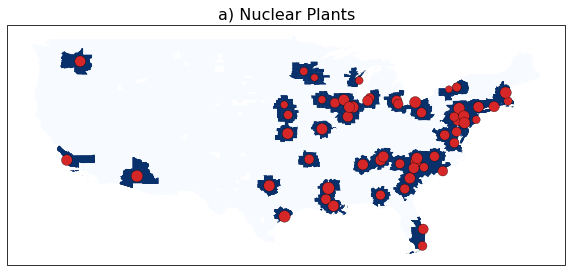

In [57]:
fig, ax = plt.subplots(figsize=[10,5], subplot_kw={'projection':ccrs.LambertConformal()})
mod_factor = 80000

###### Nuclear Plot ######

plants = ['Nuclear'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']


###### Create axes ######
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('a) Nuclear Plants', fontsize = 16)

###### plot #######
final_df.reset_index().plot(ax = ax, column = 'nuclear_adjacent', cmap='Blues' )


#create lat and lon 
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c='C3', s = size, linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 1.)



## Overall Difference in Exposure by Race

In [68]:
print('PM25')
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re)
    for run in ['nonuc']:
        print(run)
        print(final_df.xs(re, level =1)[f'PM25_{run}'].mean())

print('\n O3')
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re)
    for run in ['nonuc']:
        print(run)
        print(final_df.xs(re, level =1)[f'O3_{run}'].mean())

PM25
American Indian or Alaska Native
nonuc
0.09585940354663441
Asian or Pacific Islander
nonuc
0.17259443758044676
Black or African American
nonuc
0.22050099637259646
Hispanic or Latino
nonuc
0.14630725032220707
White
nonuc
0.19782611901240435

 O3
American Indian or Alaska Native
nonuc
0.2134835624072444
Asian or Pacific Islander
nonuc
0.4028198863001332
Black or African American
nonuc
0.6200892250127134
Hispanic or Latino
nonuc
0.3340465729816392
White
nonuc
0.469089910418823


KeyError: 'White PMnonuc'

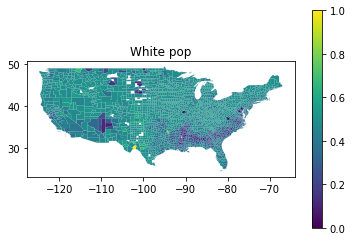

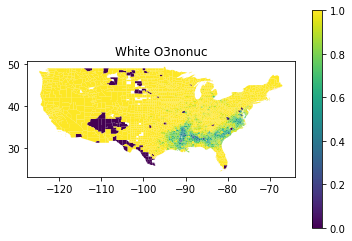

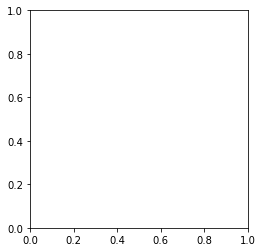

In [43]:
for idx in geo_perc_dict.keys():
    geo_perc_dict[idx].plot(column = idx, legend = True, vmin = 0, vmax = 1)
    plt.title(idx)

## Overall Difference in Mortality by Race

In [69]:
CI = 'mean'
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    for run in ['nonuc_coal']:
        print(re, run)
        print('PM25: ', (final_df.xs(re, level = 1)[f'Δmortality_PM_{CI}_{run}'].sum()/
               final_df.xs(re, level = 1)['Population'].sum())*1e6)
        print('Ozone: ', (final_df.xs(re, level = 1)[f'Δmortality_O3_{CI}_{run}'].sum()/
               final_df.xs(re, level = 1)['Population'].sum())*1e6)

American Indian or Alaska Native nonuc_coal
PM25:  5.276621674585539
Ozone:  -8.222190626117687
Asian or Pacific Islander nonuc_coal
PM25:  3.4068512674165956
Ozone:  -0.9553670814358876
Black or African American nonuc_coal
PM25:  39.49326966740414
Ozone:  5.6973719207797515
Hispanic or Latino nonuc_coal
PM25:  1.7414920950621093
Ozone:  -1.048946285956613
White nonuc_coal
PM25:  10.737037854843614
Ozone:  6.447912597478974


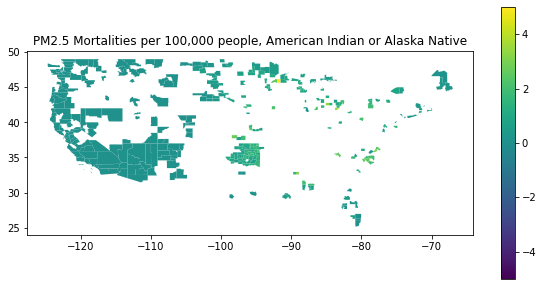

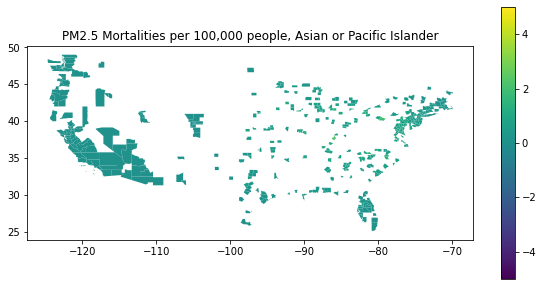

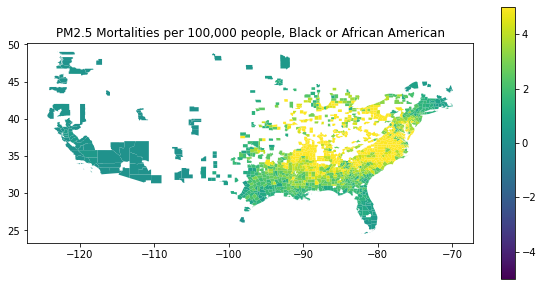

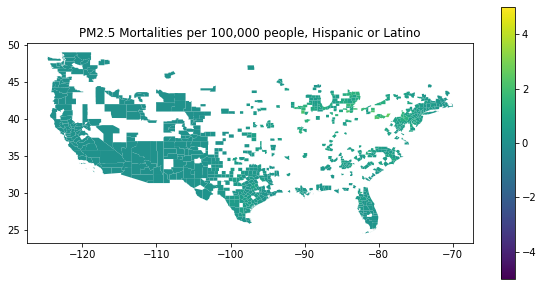

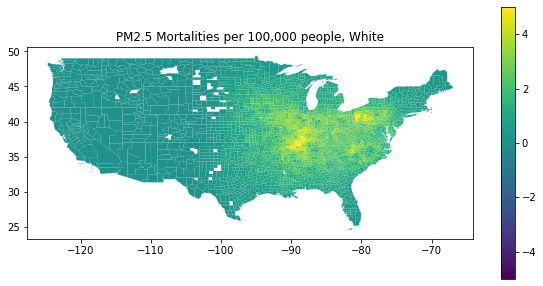

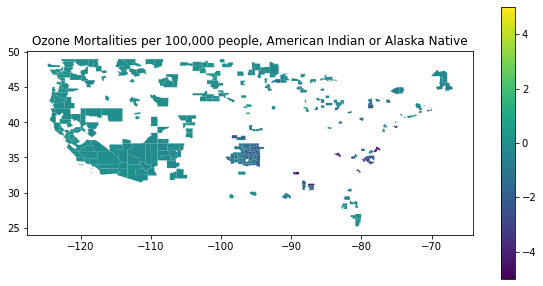

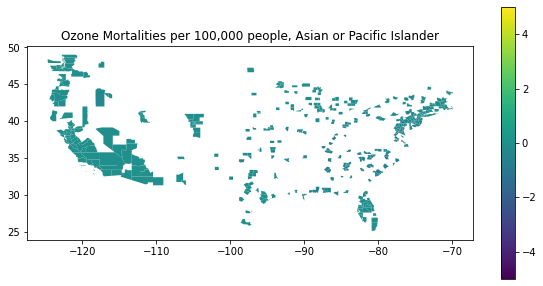

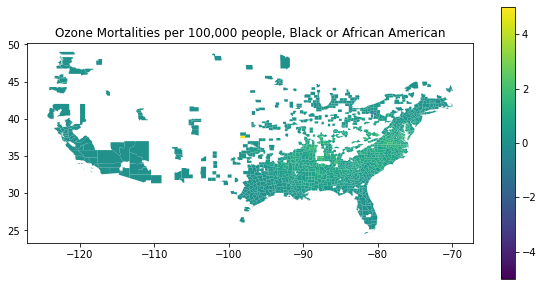

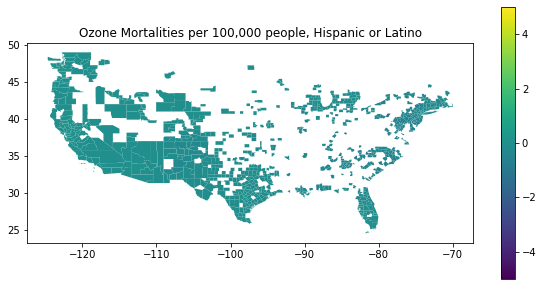

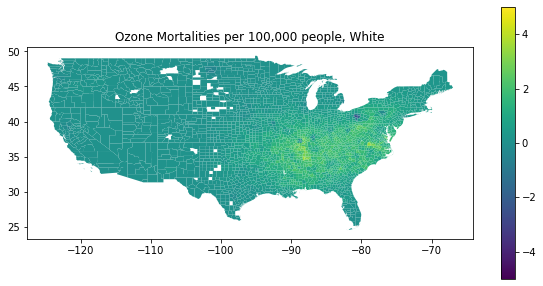

In [108]:
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    final_df.xs(re, level = 1).plot(column = 'PM_mortalities/population', figsize = (10,5), legend = True, vmax = 5, vmin = -5)
    
    plt.title('PM2.5 Mortalities per 100,000 people, ' + re)
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    final_df.xs(re, level = 1).plot(column = 'O3_mortalities/population', figsize = (10,5), legend = True, vmax = 5, vmin = -5)
    
    plt.title('Ozone Mortalities per 100,000 people, ' + re)


# State level pollution

<AxesSubplot:>

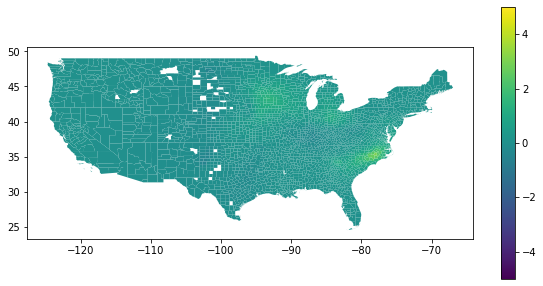

In [98]:
final_df.xs('White', level = 1).plot(column = 'PM25_nonuc_coal', figsize = (10,5), legend = True, vmax = 5, vmin = -5)

In [111]:
combined_df.groupby('state').mean()

,County Code,Deaths,Population,index_nonuc,nuclear_adjacent,coal_containing,COUNTYNS,PM25_nonuc,O3_nonuc,index_nonuc_coal,...,Δmortality_O3_mean_nonuc,Δmortality_O3_mean_nonuc_coal,β_O3_low,Δmortality_O3_low_nonuc,Δmortality_O3_low_nonuc_coal,β_O3_high,Δmortality_O3_high_nonuc,Δmortality_O3_high_nonuc_coal,O3_mortalities/population,PM_mortalities/population
state,,,,,,,,,,,,,,,,,,,,,
alabama,1068.849765,491.173709,44907.201878,1320.417840,0.309859,0.164319,1.616082e+05,0.217854,0.905346,1320.417840,...,0.394809,0.712723,0.000343,0.338983,0.608548,0.000939,0.443364,0.802695,1.947575,1.698120
arizona,4014.797468,1433.227848,174396.493671,1815.987342,0.405063,0.253165,3.165871e+04,0.006992,0.045982,1815.987342,...,-0.001749,-0.039262,-0.002034,-0.005638,-0.011162,-0.000588,0.002024,-0.065928,0.061423,-0.220389
arkansas,5075.296651,302.143541,27671.272727,1380.387560,0.234450,0.086124,6.828082e+04,0.227335,0.724431,1380.387560,...,0.218322,0.321394,0.000633,0.192306,0.280852,0.001111,0.241823,0.357501,1.550600,0.592984
california,6059.584192,1801.274914,269017.896907,1034.364261,0.082474,0.044674,6.380767e+05,0.015482,0.016143,1034.364261,...,0.009088,0.000957,-0.001773,-0.000610,0.008681,-0.000430,0.017912,-0.006118,-0.009659,0.166201
colorado,8057.505263,393.805263,57651.231579,1388.605263,0.000000,0.289474,2.349391e+05,0.009420,0.073376,1388.605263,...,0.017223,-0.181722,-0.001022,0.013079,-0.134866,-0.000067,0.021055,-0.224839,0.055288,-0.613838
connecticut,9007.702703,1649.729730,192297.972973,1044.459459,1.000000,0.135135,2.127213e+05,0.121693,0.456012,1044.459459,...,0.536395,1.317598,-0.000920,0.452159,1.113173,-0.000025,0.613596,1.505119,0.217569,0.838797
delaware,10002.750000,1107.062500,117116.000000,818.750000,1.000000,0.250000,2.172701e+05,0.269287,0.782741,818.750000,...,0.698819,1.676346,-0.000942,0.594322,1.434989,-0.000038,0.791369,1.891084,0.631029,3.128530
district of columbia,11001.000000,1677.833333,224545.833333,57.000000,1.000000,0.000000,1.702382e+06,0.286013,0.766728,57.000000,...,0.823463,1.308603,-0.001100,0.469998,0.746896,-0.000136,1.097292,1.743757,0.157359,1.912492
florida,12068.663158,1383.473684,144231.912281,1342.845614,0.305263,0.161404,2.999506e+05,0.080225,0.217601,1342.845614,...,0.134988,0.384216,-0.000929,0.112295,0.306011,0.000049,0.155455,0.454261,0.189439,0.493173
